# Evaluating the impacts of financial and non-financial barriers to adoption of technologies through the CARAT tool and bass diffusion modeling

This notebook's purpose is to present a turnkey application to study technology adoption through Bass diffusion modeling. The Bass model parameters are determined according to Hanes et al. (2019) [1] methodology and user inputs.  The application:

- Requires the answers (scores) from a Commercial Adoption Readiness Assessment Tool (CARAT) assessment.

- Determines the adoption score and associated Bass model parameters.

- Draws the adoption curves and exports raw output data.

- Accounts for the uncertainty in weighting technology attributes.

[1] Hanes, R., Carpenter, A., Riddle, M., Graziano, D. J., & Cresko, J. (2019). Quantifying adoption rates and energy savings over time for advanced energy-efficient manufacturing technologies. Journal of Cleaner Production, 232, 925-939. doi:https://doi.org/10.1016/j.jclepro.2019.04.366

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import exp
import matplotlib.ticker as mtick
from typing import Type
import random
from fuzzywuzzy import fuzz

## Determining the adoption score

Several factors may explained the adoption of new technologies. The Bass diffusion model uses a simple mathematical function with two parameters: $p$ and $q$, that can act as proxies for a variety of underlying factors. Barriers such as regulations, price competitivity, and public acceptance are factor that can explain a fast or slow technology adoption [2]. 
<br>

The questions in the [CARAT tool](https://www.energy.gov/sites/default/files/2023-03/Commercial%20Adoption%20Readiness%20Assessment%20Tool%20%28CARAT%29_030323.pdf) must be answered as accurately as possible. The questions assess what potential barriers may mitigate the adoption of a new technology. Techno-economic analysis, life cycle assessment, regulatory assessment results should be used to answer the questions. Record the answers (using the Low, Medium, High scale from the CARAT tool) in the CARAT_scores.csv template.
<br>

Based on the answers, the adoption score $s$ is calculated. From the adoption score, the Bass model parameters $p$ and $q$ are computed, following Hanes et al. (2019) methodology [1].
<br>

[2] Fleiter, T., Hirzel, S., & Worrell, E. (2012). The characteristics of energy-efficiency measures – a neglected dimension. Energy Policy, 51, 502-513. doi:https://doi.org/10.1016/j.enpol.2012.08.054

In [2]:
# The code below upload data from a csv files into a pandas data frame object

def upload_data(file_name: str) -> Type[pd.DataFrame]:
    """Upload data from a csv file and convert them into a Pandas DataFrame.
    
    Args:
        file_name (str): file name from which data needs to be uploaded from.
    
    Returns:
        df (Pandas DataFrame): Pandas DataFrame containing p and q values from the csv file.
    """
    df = pd.read_csv(file_name)
    return df

In [3]:
# Upload CARAT tool answers into a dataframe

# df = upload_data('CARAT_scores_Cement_SCM.csv')
df = upload_data('CARAT_scores_Cement_Elec.csv')

### Converting the CARAT's answers into an adoption score

The functions below converts answers to the question above into the adoption score $s$. First qualitative answers are converted into quantitatives ones.

In [4]:
def find_closest_match_kw(x: Type[pd.DataFrame], dic_kw_score: dict) -> Type[pd.Series]:
    """Convert qualitative scores (low, medium, high scale) into quantitative scores.
    
    Args:
        x (pd.DataFrame): the data frame containing the qualitative scores in a pandas series.
        dic_kw_score (dict): dictionary containing the correspondance between qualitative scores and quantitative values.
    
    Returns:
        scores (pd.Series): converted qualitative scores (to quantitative ones).
    """
    
    score_series = x['Score']

    out = None
    
    for k, v in dic_kw_score.items():
        match_score = fuzz.token_set_ratio(score_series, k)
        if match_score >= 70:
            out = v
    
    if out is not None:
        return out
    else:
        raise ValueError(f"Issue with score '{score_series}'! Try using only 'Low', 'Medium', 'High', and 'NA' to score dimensions.")

In [5]:
# Convert qualitative CARAT scores into quantitative ones in order to calculate the adoption score

dic_kw_score = {'Low': 1, 'Medium': 0.5, 'High': 0, 'NA': np.nan}

df['Quantitative score'] = df.apply(lambda x: find_closest_match_kw(x, dic_kw_score), axis=1, result_type='expand')

# Remove "NA" answers from data frame
df.dropna(inplace=True)

df.head()

,Dimension,Score,Quantitative score
0,Delivered cost,Medium,0.5
1,Functional performance,Medium,0.5
2,Ease of use / complexity,Medium,0.5
3,Demand maturity / market opennes,High,0.0
4,Market size,Medium,0.5


Next, the weights $w_c$ for each barrier (or attribute) need to be determined.

In [6]:
# The code below determine weights, either defaulting to equal or user-defined weights 

def determine_attribute_weights(x: Type[pd.DataFrame], provided_weights: dict = {}, df: Type[pd.DataFrame] = df) -> Type[pd.Series]:
    """Default to equal weighting or use a list of user-defined weights.
    
    Args:
        x (pd.DataFrame): the data frame containing all the CARAT tool dimension names in a pandas series.
        provided_weights (list): optional argument containing the user-defined weight. If not provided, default to empty dict.
    
    Returns:
        weight (pd.Series): new pandas series containing weights.
    """
    
    name_dimension = x['Dimension']
    
    if provided_weights:
        # Normalize weights; after this operation, the sum of weights will equal 1
        tot_weight = sum(provided_weights.values())
        
        if tot_weight <= 0:
            raise ValueError("Something is wrong with the weights, provide new ones.")
        else:
            provided_weights = {x: y / tot_weight for x, y in provided_weights.items()}

        return provided_weights[name_dimension]
    
    else:
        return 1 / df.shape[0]

In [7]:
df['Weight'] = df.apply(lambda x: determine_attribute_weights(x), axis=1, result_type='expand')

In [8]:
# Provides a snapshot of the data frame
df.head()

,Dimension,Score,Quantitative score,Weight
0,Delivered cost,Medium,0.5,0.058824
1,Functional performance,Medium,0.5,0.058824
2,Ease of use / complexity,Medium,0.5,0.058824
3,Demand maturity / market opennes,High,0.0,0.058824
4,Market size,Medium,0.5,0.058824


Finally, the adoption score $s$ is computed: $s = \sum_{c} w_c * Score_c$.

In [9]:
# The code below compute the adoption score

adoption_score = round(sum([x * y for x, y in zip(df['Weight'].to_list(), df['Quantitative score'].to_list())]), 2)
print(f'Given the answers to the questions on adoption barriers and their estimated relative importance, \
the adoption score is {adoption_score}.')

Given the answers to the questions on adoption barriers and their estimated relative importance, the adoption score is 0.53.


## Calculating the Bass model parameters

The Bass diffusion model parameters $p$ and $q$ are calculated from the adoption score $s$ according to Hanes et al. (2019) methodology [1] (method 2).

### Upload and prepare $p$ and $q$ empirical data

The functions below prepare a data frame containing empirical values for $p$ and $q$. The type of technology can be specified to improve the Bass model robustness.

In [10]:
qp_df = upload_data('qp_data.csv')

In [11]:
# The code below prompt the choice of technology type and prepare the data frame for the determination of what p and q
# could be given the adoption barriers assessment

def prep_qp_data(df: Type[pd.DataFrame], technology_choice: str = 'Unknown/NA?') -> Type[pd.DataFrame]:
    """Modify the input data frame to determine p and q later on.
    
    Args:
        df (Pandas DataFrame): Pandas DataFrame containing p and q values from the csv file.
    
    Returns:
        new_df (Pandas DataFrame): modified Pandas DataFrame containing p and q values from the csv file.
    """

    new_df = df.copy()
    
    if technology_choice != 'Unknown/NA?':
        tech_types = {}
        
        for tech_type in df['category'].unique():
            match_score = fuzz.token_set_ratio(tech_type, technology_choice)
            tech_types[tech_type] = match_score
        
        closest_match = max(tech_types, key=tech_types.get)
        new_df = new_df[new_df['category'] == closest_match]
    
    new_df['q/p'] = new_df['q'] / new_df['p']
    new_df = new_df.sort_values(by=['q'], ascending=True)
    adoption_score_increment = 1 / new_df.shape[0]
    adoption_score_bins = np.arange(0, 1, adoption_score_increment)
    new_df['adoption_score_mapping'] = adoption_score_bins
    
    return new_df

In [12]:
qp_df = prep_qp_data(qp_df)
qp_df.head()

,technology,category,p,q,m,source,technology ready year,market year,time to 95% adoption,q/p,adoption_score_mapping
56,Fluorescent Lamp,housewares,0.00082,0.0546,NaN,"Kohli, Lehmann and Pae, 1999",1934.0,1938,NaN,66.585366,0.000000
22,Steel: Open hearth,industrial,0.00020,0.0700,NaN,"Pae Lehmann, 2003",NaN,1868,125.432694,350.000000,0.008547
116,Electric Knife,housewares,0.09670,0.0703,NaN,"Kohli, Lehmann and Pae, 1999",1963.0,1963,NaN,0.726991,0.017094
108,Compact fluorescent,buildings,0.00750,0.0710,0.5,PNNL,NaN,1986,67.485993,9.466667,0.025641
115,condensing gas furnace,buildings,0.07000,0.0710,0.3,PNNL,NaN,1982,26.031895,1.014286,0.034188


### Determine $p$ and $q$ parameters based on empirical data

The cell below first map an empirical $q$ value to the adoption score following the method 2 from Hanes et al. (2019) [1]. Then the $p$ value is calculated using $q$ and the median value of empirical $q/p$ values.

In [13]:
# The code below compute the p value based on a mapping of the adoption score and empirical q values and the q/p median value

q_row_index = qp_df['adoption_score_mapping'].sub(adoption_score).abs().idxmin()
q = float(qp_df.loc[[q_row_index]]['q'].iloc[0])
qp_median = qp_df['q/p'].median()
p =  q / qp_median

print(f'Given the adoption score and empirical q and p values, p={p} and q={q}.')

Given the adoption score and empirical q and p values, p=0.00523875968992248 and q=0.3379.


## Drawing the correpsonding Bass adoption curve and export data

Finally, technology adoption can be studied with the parameterized Bass diffusion model. First, the studied period needs to be defined.

In [14]:
start_date = 2025
end_date = 2050

In [15]:
# The code below define a list of years covering the studied period

years = []
for i in range(end_date - start_date):
    years.append(i + start_date)
years.append(end_date)

Then, the bass diffusion model simulate adoption through the studied period. The model can be summarized with the following equation:

$$F(T) = \frac{1 - e^{-(p+q)t}}{1 + \frac{q}{p} e^{-(p+q)t}} $$

With $F(T)$ the fraction of population (of organizations or consumers) that has adopted the new technology at time $t$, $p$ the coefficient of innovation and $q$ the coefficient of imitation.

In [16]:
# Function that applies the Bass diffusion model and export raw data to a csv file

def bass_diffusion_model(years: list, p: float, q: float) -> Type[pd.DataFrame]:
    """Create a data frame containing the adoption rates throughout the studied period according to the Bass diffusion model.
    
    Args:
        years (list): list containing each year within the studied period (x axis values of the adoption curve).
        p: Bass diffusion model parameter (coefficient of innovation)
        q: Bass diffusion model parameter (coefficient of imitation)
    
    Returns:
        output_df (Pandas DataFrame): data frame containing the adoption rates (y axis values of the adoption curve) and 
            correcsonding years (x axis values of the adoption curve).
    """
    bass_adoption = []
    for t in range(len(years)):
        bass_adopt_t = (1 - exp(-1 * (p + q) * t)) / (1 + (q / p) * exp(-1 * (p + q) * t)) * 100
        bass_adoption.append(bass_adopt_t)

    output_df = pd.DataFrame({'Year': years, 'Adoption rate': bass_adoption})
    
    return output_df

output_df = bass_diffusion_model(years, p, q)
output_df.to_csv('NewTechnology_BassModelAdoptionRate_RawData.csv')
output_df.head()

,Year,Adoption rate
0,2025,0.000000
1,2026,0.621102
2,2027,1.483475
3,2028,2.673769
4,2029,4.303310


Finally, the Bass diffusion curve can be drawn:

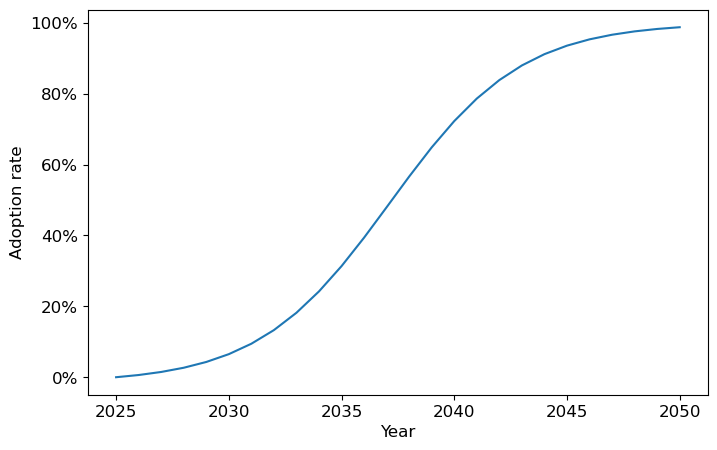

In [17]:
# Draw the Bass adoption curve and export figure

fig = plt.figure(figsize=(8, 5))
plt.rcParams.update({'font.size':12})

g = sns.lineplot(data=output_df, x="Year", y='Adoption rate')
g.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.savefig('NewTechnology_BassModelAdoptionRate.png', bbox_inches='tight', pad_inches=0.1)

## Accounting for the uncertainty in weighting technology attributes

This section of the notebook will re-draw the adoption curve accoutning for the uncertainty in weighting the different barriers (or attributes). The adoption curve can be re-drawn under low (+/- 20%), intermediate (+/- 60%), or high (+/- 100%) uncertainty.

A Monte Carlo analysis is used to re-draw the adoption curve under uncertainty. The number of Monte Carlo iterations is a user-defined parameter defaulting to 100.

In [18]:
# The function below run the Monte Carlo Analysis

# Initializes random seed
np.random.seed(0)

def monte_carlo_analysis(df: Type[pd.DataFrame], qp_df: Type[pd.DataFrame], mc_iterations: int = 100, uncertainty_level: str = 'high') -> Type[pd.DataFrame]:
    """Monte Carlo analysis with a user-defined number of iterations.
    
    Args:
        df (Pandas DataFrame): Pandas DataFrame containing all the original weights and quantitative scores.
        mc_iterations: number of Monte Carlo iterations.
    
    Returns:
        all_iterations_df (Pandas DataFrame): modified Pandas DataFrames containing values for the Monte Carlo analysis.
    """

    all_iterations_df = pd.DataFrame()

    # The function below add uncertainty to current weights
    def add_uncertainty_to_weights(x: Type[pd.DataFrame], uncertainty_level: str = 'high') -> Type[pd.Series]:
        """Add uncertainty to input weights. Default to high uncertainty.
        
        Args:
            x (pd.DataFrame): the data frame containing all the original weights in a pandas series.
            uncertainty_level: string defining the level of uncertainty.
        
        Returns:
            new weight (pd.Series): new pandas series containing weights with added uncertainty.
        """
        qual_to_quant_uncertainty_map = {'low': 0.2, 'intermediate': 0.6, 'high': 1}
        uncertainty_level_score = 1 
    
        for k, v in qual_to_quant_uncertainty_map.items():
            match_score = fuzz.token_set_ratio(uncertainty_level, k)
            if match_score >= 80:
                uncertainty_level_score = v
        
        original_weight = x['Weight']
        uncertainty = np.random.uniform(low=(-1 * uncertainty_level_score), high=uncertainty_level_score)
    
        # Return new weight. Note that the sum of the new weights may not be equal to 1 anymore
        return original_weight * (1 + uncertainty)
    
    for i in range(mc_iterations):
        
        print(f'Performing the {i + 1} out of {mc_iterations} Monte Carlo analysis iterations.', end="\r", flush=True)      

        df_inter = df.copy()
        df_inter['Weight with added uncertainty'] = df_inter.apply(lambda x: add_uncertainty_to_weights(
            x, uncertainty_level), axis=1, result_type='expand')

        adoption_score = round(sum([x * y for x, y in zip(
            df_inter['Weight with added uncertainty'].to_list(), df['Quantitative score'].to_list())]), 2)
        
        q_row_index = qp_df['adoption_score_mapping'].sub(adoption_score).abs().idxmin()
        q = float(qp_df.loc[[q_row_index]]['q'].iloc[0])
        qp_median = qp_df['q/p'].median()
        p =  q / qp_median
        
        mc_iteration_df = bass_diffusion_model(years, p, q)
        mc_iteration_df['Monte Carlo iteration'] = i
        all_iterations_df = pd.concat([all_iterations_df, mc_iteration_df])
    
    return all_iterations_df

In [19]:
all_iterations_df = monte_carlo_analysis(df, qp_df, 100)
all_iterations_df.to_csv('NewTechnology_UncertainBassModelAdoptionRate_RawData.csv')

Finally, the Bass diffusion curve under uncertainty can be drawn. Note that the figure shows the 95% most common adoption curves from the Monte Carlo sample (the 5% most extreme in either direction (slower or faster adoption) are excluded).

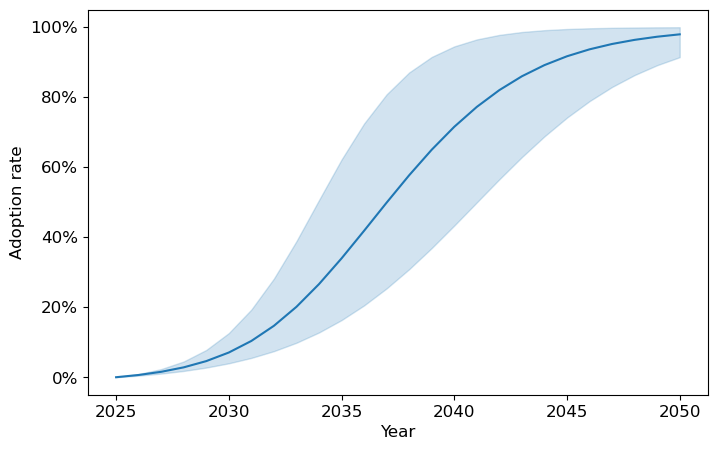

In [20]:
# Draw the Bass adoption curve and export figure

fig = plt.figure(figsize=(8, 5))
plt.rcParams.update({'font.size':12})

# Errorbar='pi' select the 95% most common curves.
g = sns.lineplot(data=all_iterations_df, x="Year", y='Adoption rate', errorbar='pi')
g.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.savefig('NewTechnology_UncertainBassModelAdoptionRate.png', bbox_inches='tight', pad_inches=0.1)